# Binning the selected profiles

QC criteria is entered to select certain profiles, then it generates binned data at standard depth levels

(1) binning adjusted O2 profiles (monthly)

(2) calculate statistical mean, standard deviation, sample count


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# prepare grid cells
xW=np.arange(-180,180,1)
yS=np.arange(-90,90,1)
xC=np.arange(-180,180,1)+0.5
yC=np.arange(-90,90,1)+0.5
xE=np.arange(-180,180,1)+1.0
yN=np.arange(-90,90,1)+1.0
# time axis
Y=np.arange(2010,2021,1)
M=np.arange(1,13,1)
# empty array
mn=np.empty((360,180,26,12,np.size(Y))) # stat mean
sd=np.empty((360,180,26,12,np.size(Y))) # stdev
dd=np.empty((360,180,26,12,np.size(Y))) # count

In [3]:
# read in the summary statistics
df=pd.read_csv('float_summary_statsitics.csv')
rmse=df['RMSE_ADJ(500-2000m)'][:]
rmse0=df['RMSE_ADJ(0-2000m)'][:]

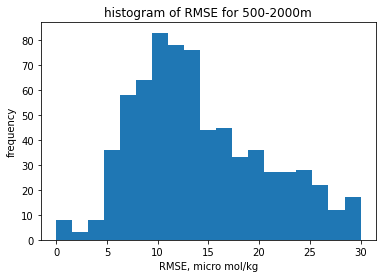

based on 500-2000m RMSE data
there are  1528  DOXY profiles
there are  206  acceptable profiles (rmse < 10uM)


In [4]:
# find very good ones
ind=np.where(rmse<=10)
#
bins=np.linspace(0,30,20)
hdat=plt.hist(rmse,bins)
plt.title('histogram of RMSE for 500-2000m')
plt.xlabel('RMSE, micro mol/kg')
plt.ylabel('frequency')
plt.show()
fn=df['File'].to_numpy()
print('based on 500-2000m RMSE data')
print('there are ',np.size(rmse),' DOXY profiles')
print('there are ',np.size(ind),' acceptable profiles (rmse < 10uM)')
plt.show()

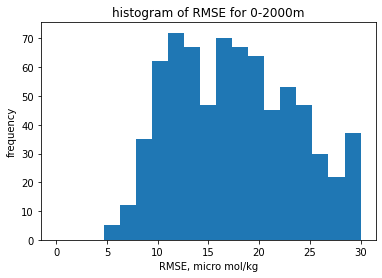

based on 0-2000m and 500-2000m RMSE data
there are  100  acceptable profiles (rmse < 15uM for 0-2000m, and 10 for 500-2000m)


In [5]:
# find very good ones
ind=np.where((rmse0<=15)&(rmse<10))
#
bins=np.linspace(0,30,20)
hdat=plt.hist(rmse0,bins)
plt.title('histogram of RMSE for 0-2000m')
plt.xlabel('RMSE, micro mol/kg')
plt.ylabel('frequency')
plt.show()
fn=df['File'].to_numpy()
print('based on 0-2000m and 500-2000m RMSE data')
print('there are ',np.size(ind),' acceptable profiles (rmse < 15uM for 0-2000m, and 10 for 500-2000m)')
plt.show()

In [6]:
def gen_stats(n): 
    # open the data file
    fltid=re.findall('\d+',fn[n])
    print('reading in '+fn[n])
    ds=xr.open_dataset(fn[n])
    Ns=np.shape(ds.O2_FLT) # profile, depth
    date=ds['JULD']
    time=pd.to_datetime(date)
    for p in range(0,Ns[0]):
        O2_FLT=ds.O2_FLT[p,:]
        x0=ds.LONGITUDE[p].data
        y0=ds.LATITUDE[p].data
        yr=int(time[p].year)
        mo=int(time[p].month)
        ix=np.where((x0>=xW)&(x0<xE))
        iy=np.where((y0>=yS)&(y0<yN))
        iyr=np.where((yr==Y))[0]
        imo=np.where((mo==M))[0]
        if (iyr.size>0):
            #print('(i,j,imo,iyr)=',str([ix,iy,imo,iyr]))
            for k in range(0,26):
                if (np.isnan(O2_FLT[k])==False):
                    mn[ix,iy,k,imo,iyr]=np.squeeze(mn[ix,iy,k,imo,iyr])+O2_FLT[k]
                    sd[ix,iy,k,imo,iyr]=np.squeeze(sd[ix,iy,k,imo,iyr])+O2_FLT[k]**2
                    dd[ix,iy,k,imo,iyr]=np.squeeze(dd[ix,iy,k,imo,iyr])+1
                    
    return ds

In [7]:
# run through all of the good profiles
for n in range(0,np.size(ind)):
    gen_stats(ind[0][n])

reading in compare_woa/1900722_26lev.nc
reading in compare_woa/1901152_26lev.nc
reading in compare_woa/1901153_26lev.nc
reading in compare_woa/1901154_26lev.nc
reading in compare_woa/1901158_26lev.nc
reading in compare_woa/1901159_26lev.nc
reading in compare_woa/2901555_26lev.nc
reading in compare_woa/2902210_26lev.nc
reading in compare_woa/2902211_26lev.nc
reading in compare_woa/2902757_26lev.nc
reading in compare_woa/2902762_26lev.nc
reading in compare_woa/2902823_26lev.nc
reading in compare_woa/3901999_26lev.nc
reading in compare_woa/3902114_26lev.nc
reading in compare_woa/3902120_26lev.nc
reading in compare_woa/3902130_26lev.nc
reading in compare_woa/3902132_26lev.nc
reading in compare_woa/4900484_26lev.nc
reading in compare_woa/4900485_26lev.nc
reading in compare_woa/4900487_26lev.nc
reading in compare_woa/5901315_26lev.nc
reading in compare_woa/5901316_26lev.nc
reading in compare_woa/5901317_26lev.nc
reading in compare_woa/5901491_26lev.nc
reading in compare_woa/5901696_26lev.nc


In [8]:
# calculate mean
mn=mn/dd

/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_94772/2706152541.py:1: RuntimeWarning: invalid value encountered in true_divide
  mn=mn/dd


In [9]:
# calculate standard deviation
sd=np.sqrt(sd/dd - mn**2)

/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_94772/1736079068.py:1: RuntimeWarning: invalid value encountered in true_divide
  sd=np.sqrt(sd/dd - mn**2)


In [20]:
# save the result
zstd=np.array([0,10,20,30,50,75,100,125,150,200,250,300,400,
               500,600,700,800,900,1000,1100,1200,1300,1400,
               1500,1750,2000])
time = pd.date_range("2010-01-01", freq="M", periods=np.size(Y)*12)
o_mn=xr.DataArray( np.empty((360,180,26,(12*np.size(Y)))) ,  
                       [("longitude",xC),("latitude",yC), 
                        ("depth",zstd),("time",time) 
                       ],name='statistical mean of o2' )
o_sd=xr.DataArray( np.empty((360,180,26,(12*np.size(Y)))) ,  
                       [("longitude",xC),("latitude",yC), 
                        ("depth",zstd),("time",time) 
                       ],name='standard deviation of o2' )
o_dd=xr.DataArray( np.empty((360,180,26,(12*np.size(Y)))) ,  
                       [("longitude",xC),("latitude",yC), 
                        ("depth",zstd),("time",time) 
                       ],name='sample count' )
for i in range(0,np.size(Y)):
    for j in range(0,np.size(M)):
        tind=12*(i-1)+j
        o_mn[:,:,:,tind]=mn[:,:,:,j,i]        
        o_sd[:,:,:,tind]=sd[:,:,:,j,i]        
        o_dd[:,:,:,tind]=dd[:,:,:,j,i]        

ds_out=xr.merge([o_mn,o_sd,o_dd])
wn='o2_ARGO_woa09bin_26lev.nc'
ds_out.to_netcdf(wn,mode='w')